In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(45)

In [2]:
class SOM:
    
    def __init__(self, width, height, dim):
        self.num_iters = 100
        self.width = width
        self.height = height
        self.dim = dim
        self.node_locs = self.get_locs()
        nodes = tf.cast(tf.Variable(tf.random.normal([width*height, dim])), tf.double)
        self.nodes = nodes
        x = np.array([dim], dtype=np.double) 
        self.x = x 
        iter = 0.
        self.iter = iter 
        bmu_loc = self.get_bmu_loc(x)
        self.propagate_nodes = self.get_propagation(x, iter)
        
    def get_propagation(self, x, iter):
        bmu_loc = self.get_bmu_loc(x)        
        num_nodes = self.width * self.height
        rate = tf.cast(1.0 - tf.divide(iter, self.num_iters), tf.double)
        alpha = rate * 0.5
        sigma = rate * tf.cast((tf.cast(tf.maximum(self.width, self.height), tf.double) / 2.), tf.double)
        expanded_bmu_loc = tf.expand_dims(tf.cast(bmu_loc, tf.double), 0)
        sqr_dists_from_bmu = tf.reduce_sum(
          tf.square(tf.subtract(expanded_bmu_loc, self.node_locs)), 1)
        neigh_factor = tf.exp(-tf.divide(sqr_dists_from_bmu, 2 * tf.square(sigma)))
        rate = tf.multiply(alpha, neigh_factor)
        rate_factor = tf.cast(tf.stack([tf.tile(tf.slice(rate, [i], [1]), [self.dim]) for i in range(num_nodes)]), tf.double)
        nodes_diff = tf.multiply(rate_factor, tf.subtract(tf.stack([x for i in range(num_nodes)]), tf.cast(self.nodes, tf.double)))
        update_nodes = tf.add(self.nodes, nodes_diff)
        self.nodes = update_nodes
    
    def get_bmu_loc(self, x):
        expanded_x = tf.expand_dims(x, 0)
        sqr_diff = tf.square(tf.subtract(tf.cast(expanded_x, tf.double), tf.cast(self.nodes, tf.double)))
        dists = tf.reduce_sum(sqr_diff, 1)
        bmu_idx = tf.argmin(dists, 0)
        bmu_loc = tf.stack([tf.math.mod(tf.cast(bmu_idx, tf.int64), tf.cast(self.width, tf.int64)), tf.cast(tf.divide(tf.cast(bmu_idx, tf.int64), tf.cast(self.width, tf.int64)), tf.int64)])
        return bmu_loc
    
    def get_locs(self):
        locs = [[x, y]
                 for y in range(self.height)
                 for x in range(self.width)]
        return tf.cast(locs, tf.double)

    def train(self, data):
        for i in range(self.num_iters):
            for data_x in data:
                self.get_propagation(data_x, i)
        centroid_grid = [[] for i in range(self.width)]
        self.nodes_val = list(self.nodes)
        self.locs_val = list(self.node_locs)
        for i, l in enumerate(self.locs_val):
            centroid_grid[int(l[0])].append(self.nodes_val[i])
        self.centroid_grid = centroid_grid


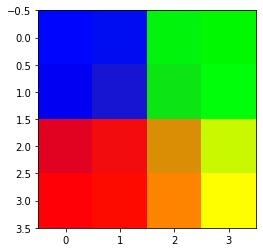

In [3]:
colors = np.array(
     [[0., 0., 1.],
      [0., 0., 0.95],
      [0., 0.05, 1.],
      [0., 1., 0.],
      [0., 0.95, 0.],
      [0., 1, 0.05],
      [1., 0., 0.],
      [1., 0.05, 0.],
      [1., 0., 0.05],
      [1., 1., 0.]])
som = SOM(4, 4, 3)
som.train(colors)
plt.imshow(som.centroid_grid)
plt.show()